In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
import time
import PIL.Image as Image
import tensorflow_hub as hub
import datetime
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [2]:
import pathlib
train_url = "https://www.alfarhood.com/PublicSharedFiles/Date_Fruit_Image_Dataset_Splitted_Train.zip"
train_dir = tf.keras.utils.get_file('train.tar', origin=train_url, extract=True)
train_dir = pathlib.Path(train_dir).with_suffix('')

test_url = "https://www.alfarhood.com/PublicSharedFiles/Date_Fruit_Image_Dataset_Splitted_Test.zip"
test_dir = tf.keras.utils.get_file('test.tar', origin=test_url, extract=True)
test_dir = pathlib.Path(test_dir).with_suffix('')

6143385/6143385 [==============================] - 1s 0us/step


In [3]:
train_count = len(list(train_dir.glob('*/*.jpg')))
print(train_count)
test_count = len(list(test_dir.glob('*/*.jpg')))
print(test_count)

1156
502


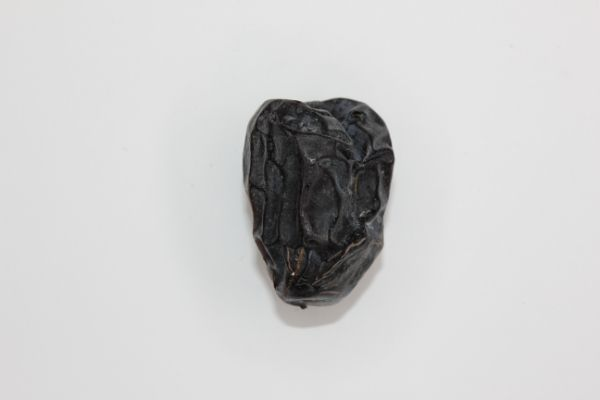

In [4]:
Ajwa = list(train_dir.glob('Ajwa/*'))
PIL.Image.open(str(Ajwa[0]))

In [5]:
img_height, img_width = 244, 244  # Adjust based on your dataset specifics
batch_size = 32

In [6]:
train_ds  = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.25,
    subset="training",
    seed=123  # For reproducibility (optional)
)

Found 1156 files belonging to 9 classes.
Using 867 files for training.


In [7]:
val_ds  = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.25,
    subset="validation",
    seed=123  # For reproducibility (optional)
)

Found 1156 files belonging to 9 classes.
Using 289 files for validation.


In [8]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False)

Found 502 files belonging to 9 classes.


In [9]:
class_names = train_ds.class_names
print(class_names)

['Ajwa', 'Galaxy', 'Mejdool', 'Meneifi', 'NabtatAli', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']


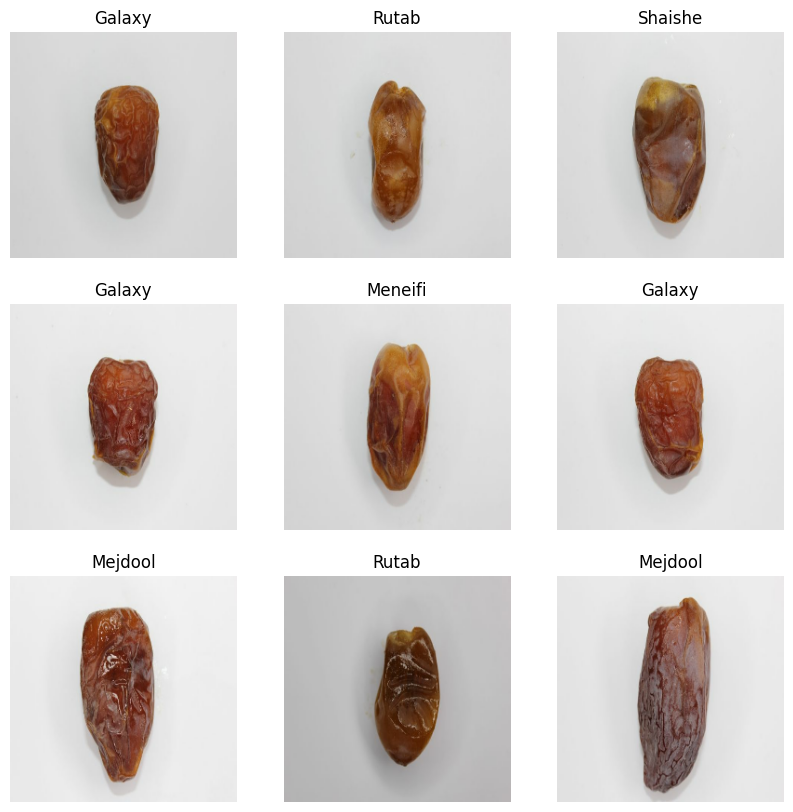

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = keras.Sequential(
    [
        #layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        #layers.RandomRotation(0.2),
        layers.RandomZoom(0.4),
        #layers.RandomCrop(img_height, img_width), # Random crop back to original dimensions
       # layers.RandomTranslation(0.3, 0.3),
        layers.RandomContrast(0.15),
        layers.RandomBrightness(0.15),
    ]
)

In [ ]:
num_classes = len(class_names)

model = models.Sequential([

    layers.Conv2D(8, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),

     layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    #layers.Dense(128, activation='relu'),

     layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),







    # Layer 7: Flattening Layer
    layers.Flatten(),
    # Layer 8: Dense Layer
    layers.Dense(512, activation='relu'),
    # Layer 9: Dropout Layer
    layers.Dropout(0.5),
    # Layer 10: Output Dense Layer
    layers.Dense(9, activation='softmax')  # Assuming 10 classes
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 242, 242, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 121, 121, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 119, 119, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 59, 59, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 32)       

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])
'''
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1)
    '''


'\nlog_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")\ntensorboard_callback = tf.keras.callbacks.TensorBoard(\n    log_dir=log_dir,\n    histogram_freq=1)\n    '

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


28/28 [==============================] - 56s 2s/step - loss: 2.1811 - acc: 0.1511 - val_loss: 2.0972 - val_acc: 0.1834
Epoch 2/20
28/28 [==============================] - 36s 1s/step - loss: 1.9184 - acc: 0.3057 - val_loss: 1.5233 - val_acc: 0.4498
Epoch 3/20
28/28 [==============================] - 32s 1s/step - loss: 1.3191 - acc: 0.5063 - val_loss: 1.0819 - val_acc: 0.6090
Epoch 4/20
28/28 [==============================] - 34s 1s/step - loss: 1.0122 - acc: 0.6378 - val_loss: 0.8404 - val_acc: 0.7093
Epoch 5/20
28/28 [==============================] - 31s 1s/step - loss: 0.8285 - acc: 0.6943 - val_loss: 0.8295 - val_acc: 0.7301
Epoch 6/20
28/28 [==============================] - 34s 1s/step - loss: 0.6512 - acc: 0.7820 - val_loss: 0.6287 - val_acc: 0.7958
Epoch 7/20
28/28 [==============================] - 33s 1s/step - loss: 0.5192 - acc: 0.8235 - val_loss: 0.5605 - val_acc: 0.8339
Epoch 8/20
28/28 [==============================] - 34s 1s/step - loss: 0.5474 - acc: 0.8051 - val_lo

16/16 [==============================] - 6s 362ms/step - loss: 61.6817 - acc: 0.8745
Test Loss: 61.68169403076172
Test Accuracy: 0.8745020031929016


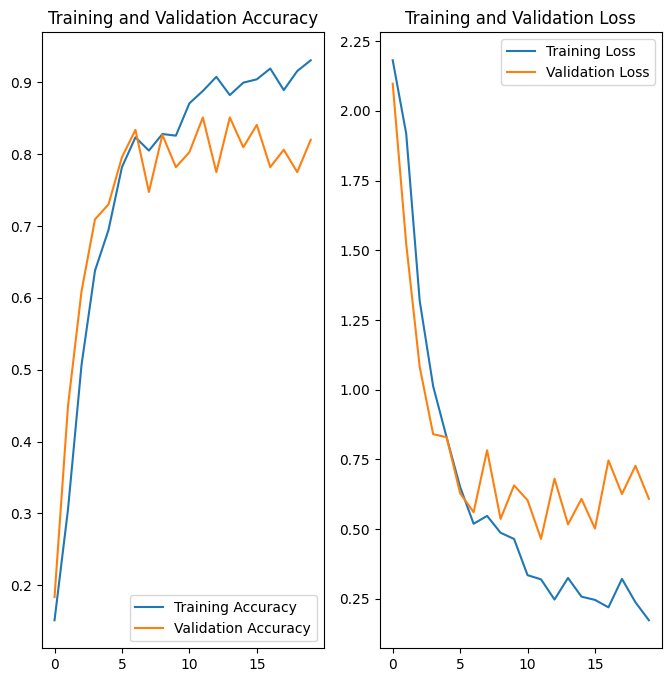

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

16/16 [==============================] - 7s 451ms/step


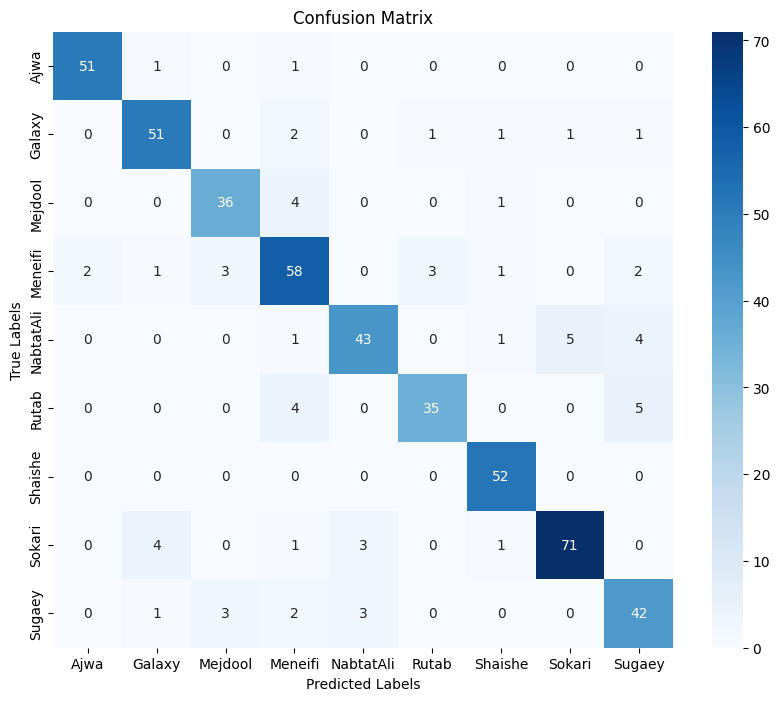

              precision    recall  f1-score   support

        Ajwa       0.96      0.96      0.96        53
      Galaxy       0.88      0.89      0.89        57
     Mejdool       0.86      0.88      0.87        41
     Meneifi       0.79      0.83      0.81        70
   NabtatAli       0.88      0.80      0.83        54
       Rutab       0.90      0.80      0.84        44
     Shaishe       0.91      1.00      0.95        52
      Sokari       0.92      0.89      0.90        80
      Sugaey       0.78      0.82      0.80        51

    accuracy                           0.87       502
   macro avg       0.88      0.87      0.87       502
weighted avg       0.88      0.87      0.87       502



In [ ]:
# Predictions
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in test_ds], axis=0)
cm = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=test_ds.class_names, yticklabels=test_ds.class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
# Classification Report
print(classification_report(true_labels, predicted_classes, target_names=test_ds.class_names))



<ipython-input-11-f95b7d8db73d>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(class_names, rotation=45, ha='right')
<ipython-input-11-f95b7d8db73d>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(class_names, rotation=45, ha='right')


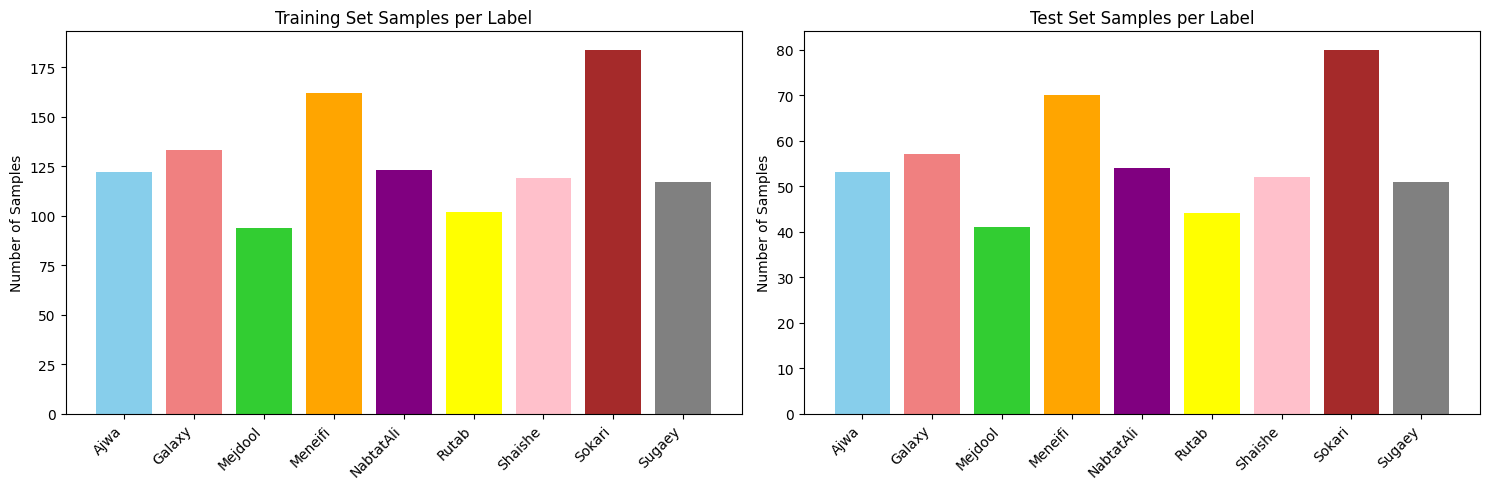

In [11]:
import matplotlib.pyplot as plt

# Define colors for each bar
colors = ['skyblue', 'lightcoral', 'limegreen', 'orange', 'purple', 'yellow', 'pink', 'brown', 'gray']

train_counts = [len(list(train_dir.glob(f'{class_name}/*.jpg'))) for class_name in class_names]
test_counts = [len(list(test_dir.glob(f'{class_name}/*.jpg'))) for class_name in class_names]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the count of samples per label for the training set with different colors
axs[0].bar(class_names, train_counts, color=colors[:len(class_names)])
axs[0].set_title('Training Set Samples per Label')
axs[0].set_ylabel('Number of Samples')
axs[0].set_xticklabels(class_names, rotation=45, ha='right')

# Plot the count of samples per label for the test set with different colors
axs[1].bar(class_names, test_counts, color=colors[:len(class_names)])
axs[1].set_title('Test Set Samples per Label')
axs[1].set_ylabel('Number of Samples')
axs[1].set_xticklabels(class_names, rotation=45, ha='right')

plt.tight_layout()
plt.show()